# Covid-19 Fake News Detection
 


In [1]:
import os
import numpy as np
import pandas as pd
import re
import torch
import nltk
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, RandomSampler
from collections import defaultdict
from typing import Dict, List

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [2]:
train_path = '/Users/rain/life/ml_proj/covid19-fake-news-detection-ml/Constraint_English_Train.xlsx'
val_path = '/Users/rain/life/ml_proj/covid19-fake-news-detection-ml/Constraint_English_Val.xlsx'
test_path = '/Users/rain/life/ml_proj/covid19-fake-news-detection-ml/Constraint_English_Test.xlsx'

# 6420 rows
train_dataset = pd.read_excel(train_path,engine='openpyxl')
# 2140 rows
val_dataset = pd.read_excel(val_path,engine='openpyxl')
# 2140 rows
test_dataset = pd.read_excel(test_path,engine='openpyxl')

In [3]:
def get_words_count(tweet):
    return len(re.split(' |,', tweet))

def get_chars_count(tweet):
    return len(tweet)

def get_urls_count(tweet):
    return len(re.findall(r'(?:https?:\/\/www|https?:\/\/|s?ftp:\/\/|www)', tweet))

def get_hashtag_cout(tweet):
    return len(re.findall('#',tweet))

dataset = train_dataset.append(val_dataset).append(test_dataset)
dataset_real = dataset[dataset['label'] == 'real']
dataset_fake = dataset[dataset['label'] == 'fake']

words_avg_real = np.vectorize(get_words_count)(dataset_real['tweet']).mean()
words_avg_fake = np.vectorize(get_words_count)(dataset_fake['tweet']).mean()
print("Average words per real tweet: ", words_avg_real)
print("Average words per fake tweet: ", words_avg_fake, '\n')

chars_avg_real = np.vectorize(get_chars_count)(dataset_real['tweet']).mean()
chars_avg_fake = np.vectorize(get_chars_count)(dataset_fake['tweet']).mean()
print("Average chars per real tweet: ", chars_avg_real)
print("Average chars per fake tweet: ", chars_avg_fake, '\n')

urls_avg_real = np.vectorize(get_urls_count)(dataset_real['tweet']).mean()
urls_avg_fake = np.vectorize(get_urls_count)(dataset_fake['tweet']).mean()
print("Average URLs per real tweet: ", urls_avg_real)
print("Average URLs per fake tweet: ", urls_avg_fake, '\n')

hashtag_avg_real = np.vectorize(get_hashtag_cout)(dataset_real['tweet']).mean()
hashtag_avg_fake = np.vectorize(get_hashtag_cout)(dataset_fake['tweet']).mean()
print("Average hashtags per real tweet: ", hashtag_avg_real)
print("Average hashtags per fake tweet: ", hashtag_avg_fake, '\n')

max_words_real = np.vectorize(get_words_count)(dataset_real['tweet']).max()
max_words_fake = np.vectorize(get_words_count)(dataset_fake['tweet']).max()
print("Maximum no. of words in a real tweet: ", max_words_real)
print("Maximum no. of words in a fake tweet: ", max_words_fake, '\n')

min_words_real = np.vectorize(get_words_count)(dataset_real['tweet']).min()
min_words_fake = np.vectorize(get_words_count)(dataset_fake['tweet']).min()
print("Minimum no. of words in a real tweet: ", min_words_real)
print("Minimum no. of words in a fake tweet: ", min_words_fake, '\n')

Average words per real tweet:  31.959642857142857
Average words per fake tweet:  21.852156862745097 

Average chars per real tweet:  217.12410714285716
Average chars per fake tweet:  143.21058823529413 

Average URLs per real tweet:  0.9505357142857143
Average URLs per fake tweet:  0.40490196078431373 

Average hashtags per real tweet:  1.0751785714285715
Average hashtags per fake tweet:  0.48980392156862745 

Maximum no. of words in a real tweet:  1433
Maximum no. of words in a fake tweet:  1409 

Minimum no. of words in a real tweet:  3
Minimum no. of words in a fake tweet:  3 



# Preprocessing

In [4]:
def decontract(tweet):
    # Eliminate links
    tweet = re.sub(r"\S*https?:\S*", "", tweet) 

    # Specific
    tweet = re.sub(r"won\'t", "will not", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)

    # General
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would", tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
    return tweet
  
new_dataset = []
for data in dataset['tweet']:
    element = decontract(data)
    new_dataset.append(element)

def replace_punctuation(tweet):
    tweet = re.sub('[^A-Za-z0-9]+', ' ', tweet.lower())
    return tweet

def split_tweet(tweet):
    tokens = tweet.split(" ")
    token_list = [x for x in tokens if x != '' and x!='https' and x!='http' and x!='s']
    return token_list

list_of_words = []
word_count = defaultdict(int)
for data in new_dataset:
    element = split_tweet(replace_punctuation(data))
    list_of_words.extend(element)

list_of_unique_words = list(set(list_of_words))

print("Number of unique words: " + str(len(list_of_unique_words)))

# Words frequency
for word in list_of_unique_words:
    word_count[word] = 0

for word in list_of_words:
    word_count[word] += 1

Number of unique words: 18409


In [5]:
# Eliminates links and all non-alphanumerical characters
# Decontracts words like "haven't" to "have not"
# Returns list of tweets, where each tweet is splitted by space

def preprocess(dataset):
    processed_dataset = []
  
    for data in dataset["tweet"]:
        decontracted_data = decontract(data)
        processed_data = split_tweet(replace_punctuation(decontracted_data))  
        processed_dataset.append(processed_data)

    return processed_dataset 

train_data = preprocess(train_dataset)
validation_data = preprocess(val_dataset)
test_data = preprocess(test_dataset)

In [6]:
words_without_vectors = []

# Creating the word to vector representation for our unique words
for word in list_of_unique_words:
    words_without_vectors.append(word)

print(len(words_without_vectors))

18409


In [7]:
# Transform labels to binary representation

def labels_to_binary(dataset, labels):
    for i in range(len(dataset['label'])):
        label = dataset['label'][i]
        if label == "fake":
            labels.append(0)
        else:
            labels.append(1)

train_labels = []
labels_to_binary(train_dataset, train_labels)
train_labels = torch.tensor(train_labels)

val_labels = []
labels_to_binary(val_dataset, val_labels)
val_labels = torch.tensor(val_labels)

test_labels = []
labels_to_binary(test_dataset, test_labels)
test_labels = torch.tensor(test_labels)

In [8]:
# Function that adds padding to a batch of data by filling the shorter tweets 
# with 0 up to the size of the longest tweet in the batch, thus making them equal sized

def collate_examples(batch_data):
    batch_input = [e[0] for e in batch_data]
    batch_labels = [e[1] for e in batch_data]
    max_len = max([len(example) for example in batch_input])

    batch_input_tensor = torch.zeros(len(batch_input), max_len).long()
    for idx, data in enumerate(batch_input):
        batch_input_tensor[idx, :data.size(0)] = data
    batch_labels_tensor = torch.cat(batch_labels)

    return (batch_input_tensor, batch_labels_tensor)

In [9]:
# Vocabulary class that initializes a collection of all the unique words in the
# dataset and maps each of them to a unique id. 

class Vocabulary:
    def __init__(self, word_count: Dict[str, int], min_freq: int):
        self.word_to_idx = {'[pad]': 0, '[unk]':1}
        next_index = 2
        for word, freq in word_count.items():
            if freq >= min_freq:
                self.word_to_idx[word] = next_index
                next_index += 1
        self.idx_to_char = {idx: word for (word, idx) in self.word_to_idx.items()}
   
    def size(self):
        return len(self.word_to_idx)
      
    def __str__(self):
        return str(self.word_to_idx)

In [10]:
class TweetDataset(Dataset):
    MAX_TWEET_LENGTH = 122

    def __init__(self, 
                 tokenized_tweets: List[List[str]], 
                 labels: Tensor,
                 vocab: Vocabulary):

        self.data = tokenized_tweets
        self.labels = labels
        self.vocabulary = vocab

    @staticmethod
    def tokenize(tweet):
        decontracted_tweet = decontract(tweet)
        processed_tweet = split_tweet(replace_punctuation(decontracted_tweet))  
        tweet_indices = []
        current_length = 0

        for word in processed_tweet:
            current_length += 1
            if current_length > TweetDataset.MAX_TWEET_LENGTH:
                break

            if word in vocab.word_to_idx:
                tweet_indices.append(vocab.word_to_idx[word])
            else:
                tweet_indices.append(1)

        return torch.LongTensor(tweet_indices)

    def __getitem__(self, index) -> (torch.Tensor, torch.Tensor):
        tweet_indices = []
        tweet = self.data[index]

        current_length = 0
        for word in tweet:
            current_length += 1
            if current_length > TweetDataset.MAX_TWEET_LENGTH:
                break

            if word in vocab.word_to_idx:
                tweet_indices.append(vocab.word_to_idx[word])
            else:
                tweet_indices.append(1)

        return torch.LongTensor(tweet_indices), torch.LongTensor([self.labels[index]])

    def __len__(self) -> int:
        return len(self.data)

In [11]:
# Initializing

vocab = Vocabulary(word_count=word_count, min_freq=2)
print("Vocab size = ", vocab.size())

train_dataset = TweetDataset(train_data, train_labels, vocab)
val_dataset = TweetDataset(validation_data, val_labels, vocab)
test_dataset = TweetDataset(test_data, test_labels, vocab)

train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)
test_sampler = RandomSampler(test_dataset)

kwargs = {'num_workers': 2, 'pin_memory': True} if device=='cuda' else {}

train_dataloader = DataLoader(train_dataset, 
                        batch_size = 64, 
                        sampler = train_sampler,
                        collate_fn = collate_examples, 
                        **kwargs)

val_dataloader = DataLoader(val_dataset,
                            batch_size = 64,
                            sampler = val_sampler,
                            collate_fn = collate_examples,
                            **kwargs)

test_dataloader = DataLoader(test_dataset,
                            batch_size = 64,
                            sampler = test_sampler,
                            collate_fn = collate_examples,
                            **kwargs)

Vocab size =  9311


# Neural Network models

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

class LSTMClassification(nn.Module):
    def __init__(self, 
              input_size: int,
              vocabulary: Vocabulary,
              vocabulary_size: int,
              hidden_size: int, 
              output_size: int,
              hidden_activation_fn):
      
        super().__init__()
        self.hidden_activation_fn = hidden_activation_fn
      
        self._embedding = nn.Embedding(vocabulary_size, input_size)
        self._lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self._layer1 = nn.Linear(hidden_size, hidden_size)
        self._layer2 = nn.Linear(hidden_size, output_size)
  
    def forward(self, x):
        x_embedding = self._embedding(x)
        output, (h_n, c_n) = self._lstm(x_embedding)
        hn_output = self._layer1(h_n.squeeze())
        return self._layer2(self.hidden_activation_fn(hn_output))


class BiLSTMClassification(nn.Module):
    def __init__(self, 
              input_size: int,
              vocabulary: Vocabulary,
              vocabulary_size: int,
              hidden_size: int, 
              output_size: int,
              hidden_activation_fn,
              dropout_rate: float):
      
        super().__init__()
        self.hidden_activation_fn = hidden_activation_fn
        self.dropout = nn.Dropout(dropout_rate)
        self._embedding = nn.Embedding(vocabulary_size, input_size)

        self._lstm = nn.LSTM(input_size, hidden_size, batch_first = True, bidirectional = True)
        self._layer1 = nn.Linear(2 * hidden_size, hidden_size)
        self._layer2 = nn.Linear(hidden_size, output_size)
  
    def forward(self, x):
        x_embedding = self._embedding(x)
        x_embedding = self.dropout(x_embedding)
        output, (h_n, c_n) = self._lstm(x_embedding)
        h_n_max = torch.max(output, dim=1)[0]
        max_output = self._layer1(h_n_max)
        return self._layer2(self.hidden_activation_fn(max_output))

# Plotting

In [13]:
from matplotlib import pyplot as plt
def plot_metrics(metrics1, metrics2, label1, label2):
    plt.figure()
    plt.plot(metrics1, c='b', label=label1)
    plt.plot(metrics2, c='g', label=label2)
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# LSTM

In [14]:
def train(model, dataloader, optim, criterion):
    
    # Set the model to train mode
    model.train()
    train_loss_batch = []
    for batch_id, (batch_data, batch_labels) in enumerate(dataloader):
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

      # reset the gradients
        optim.zero_grad()
      
      # batch_size x hidden_size
        output = model(batch_data)

        loss = criterion(output, batch_labels)
      
        loss.backward()
        optim.step()
        train_loss_batch.append(loss.detach().cpu().numpy())

        if batch_id % 25 == 0:
            print(f'\nTrain batch: {batch_id}')
            print(f'Train loss = {loss.item()}')

    return np.array(train_loss_batch).mean()

In [15]:
def validate(model, dataloader):
    model.eval()

    losses = []
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    predictions = [] 
    labels = []
    for batch_id, (batch_data, batch_labels) in enumerate(dataloader):
        with torch.no_grad():
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            output = model(batch_data)

            loss = F.cross_entropy(output, batch_labels).cpu()
            losses.append(loss)

            predicted = torch.argmax(model(batch_data), dim=-1).cpu()
            predictions.extend(predicted.tolist())

            batch_labels = batch_labels.cpu()
            labels.extend(batch_labels.tolist())

            accuracy = accuracy_score(predicted, batch_labels)
            accuracies.append(accuracy)

            precision = precision_score(predicted, batch_labels)
            precisions.append(precision)

            recall = recall_score(predicted, batch_labels)
            recalls.append(recall)

            f1 = f1_score(predicted, batch_labels)
            f1s.append(f1)

            if batch_id % 10 == 0:
                print(f'\nValidation batch: {batch_id}')
                print(f'Validation loss: {loss}')
    
    loss = np.array(losses).mean()
    accuracy = np.array(accuracies).mean()
    precision = np.array(precisions).mean()
    recall = np.array(recalls).mean()
    f1 = np.array(f1s).mean()

    return loss, accuracy, precision, recall, f1, predictions, labels

In [16]:
def test(model, dataloader):
    model.eval()

    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    for batch_id, (batch_data, batch_labels) in enumerate(dataloader):
        with torch.no_grad():
            batch_data = batch_data.to(device)

            output = model(batch_data)
            predicted = torch.argmax(model(batch_data), dim=-1).cpu()

            accuracy = accuracy_score(predicted, batch_labels)
            accuracies.append(accuracy)

            precision = precision_score(predicted, batch_labels)
            precisions.append(precision)

            recall = recall_score(predicted, batch_labels)
            recalls.append(recall)

            f1 = f1_score(predicted, batch_labels)
            f1s.append(f1)

    accuracy = np.array(accuracies).mean()
    precision = np.array(precisions).mean()
    recall = np.array(recalls).mean()
    f1 = np.array(f1s).mean()
    
    return accuracy, precision, recall, f1

### Training and validation

In [17]:
model = LSTMClassification(200, vocab, vocab.size(), 64, 2, nn.Tanh()).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 20

train_loss = []
val_loss = []
val_acc = []
val_prec = []
val_recall = []
val_f1 = []

for i in range(epochs):
    print(f'\nEPOCH: {i}')

    train_loss_epoch = train(model, train_dataloader, optim, criterion)
    train_loss.append(train_loss_epoch)

    val_loss_epoch, val_acc_epoch, val_prec_epoch, val_rec_epoch, val_f1_epoch, val_pred_epoch, val_lab_epoch = validate(model, val_dataloader)
    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)
    val_prec.append(val_prec_epoch)
    val_recall.append(val_rec_epoch)
    val_f1.append(val_f1_epoch)

    if i % 2 == 0:
        print(f'\nValidation accuracy: {val_acc_epoch}')

print(f'\nAverage train loss: {np.array(train_loss).mean()}')
print(f'\nAverage validation loss: {np.array(val_loss).mean()}')


EPOCH: 0

Train batch: 0
Train loss = 0.6929357647895813

Train batch: 25
Train loss = 0.7194646596908569

Train batch: 50
Train loss = 0.6924166679382324

Train batch: 75
Train loss = 0.6727449893951416

Train batch: 100
Train loss = 0.5625666379928589

Validation batch: 0
Validation loss: 0.6151189208030701

Validation batch: 10
Validation loss: 0.6474993228912354

Validation batch: 20
Validation loss: 0.6068952083587646

Validation batch: 30
Validation loss: 0.6161718964576721

Validation accuracy: 0.6989233193277311

EPOCH: 1

Train batch: 0
Train loss = 0.6480267643928528

Train batch: 25
Train loss = 0.350771963596344

Train batch: 50
Train loss = 0.3308907449245453

Train batch: 75
Train loss = 0.20791174471378326

Train batch: 100
Train loss = 0.3700529634952545

Validation batch: 0
Validation loss: 0.41812917590141296

Validation batch: 10
Validation loss: 0.2841283977031708

Validation batch: 20
Validation loss: 0.23456794023513794

Validation batch: 30
Validation loss: 0.34


Validation batch: 30
Validation loss: 0.6716384291648865

EPOCH: 16

Train batch: 0
Train loss = 0.00017381708312314004

Train batch: 25
Train loss = 1.55996713147033e-05

Train batch: 50
Train loss = 0.00011760438064811751

Train batch: 75
Train loss = 4.7550587623845786e-05

Train batch: 100
Train loss = 4.607404662237968e-06

Validation batch: 0
Validation loss: 0.4198487102985382

Validation batch: 10
Validation loss: 0.5367385745048523

Validation batch: 20
Validation loss: 1.1194748878479004

Validation batch: 30
Validation loss: 0.6736605763435364

Validation accuracy: 0.9129464285714286

EPOCH: 17

Train batch: 0
Train loss = 0.00012661846994888037

Train batch: 25
Train loss = 0.0002776477485895157

Train batch: 50
Train loss = 1.5868767150095664e-05

Train batch: 75
Train loss = 4.4275704567553475e-05

Train batch: 100
Train loss = 6.794884939154144e-06

Validation batch: 0
Validation loss: 0.6739436388015747

Validation batch: 10
Validation loss: 0.6441195011138916

Validat

Best val loss 0.289866 at epoch 2
Best val acc 0.915769 at epoch 13
Best val F1 0.917398 at epoch 13


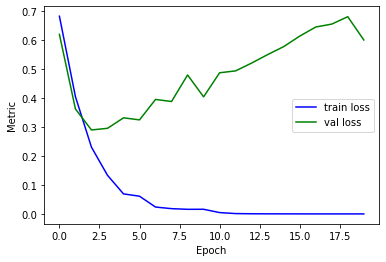

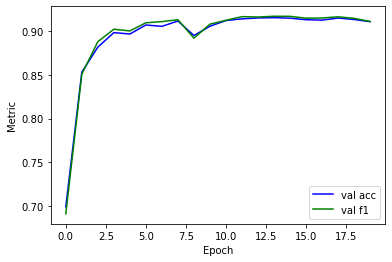

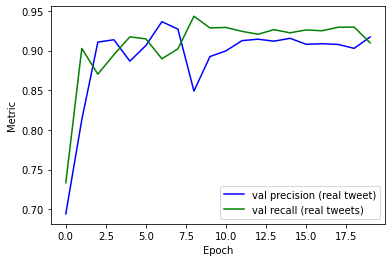

In [18]:
min_epoch = np.argmin(val_loss)
max_epoch_acc = np.argmax(val_acc)
max_epoch_f1 = np.argmax(val_f1)
print("Best val loss %f at epoch %d" % (val_loss[min_epoch], min_epoch))
print("Best val acc %f at epoch %d" % (np.max(val_acc), max_epoch_acc))
print("Best val F1 %f at epoch %d" % (np.max(val_f1), max_epoch_f1))

plot_metrics(train_loss, val_loss, 'train loss', 'val loss')
plot_metrics(val_acc, val_f1, 'val acc', 'val f1')
plot_metrics(val_prec, val_recall, 'val precision (real tweet)', 'val recall (real tweets)')

# BiLSTM



---

### Training and validation


In [19]:
model = BiLSTMClassification(200, vocab, vocab.size(), 128, 2, nn.Tanh(), 0.6).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 25

train_loss = []
val_loss = []
val_acc = []
val_prec = []
val_recall = []
val_f1 = []
val_predictions = []
val_labels = []

for i in range(epochs):
    print(f'\nEPOCH: {i}')

    train_loss_epoch = train(model, train_dataloader, optim, criterion)
    train_loss.append(train_loss_epoch)

    val_loss_epoch, val_acc_epoch, val_prec_epoch, val_rec_epoch, val_f1_epoch, val_pred_epoch, val_labels_epoch = validate(model, val_dataloader)
    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)
    val_prec.append(val_prec_epoch)
    val_recall.append(val_rec_epoch)
    val_f1.append(val_f1_epoch)
    val_predictions.append(val_pred_epoch)
    val_labels.append(val_labels_epoch)

    if i % 2 == 0:
        print(f'\nValidation accuracy: {val_acc_epoch}')

print(f'\nAverage train loss: {np.array(train_loss).mean()}')
print(f'\nAverage validation loss: {np.array(val_loss).mean()}')


EPOCH: 0

Train batch: 0
Train loss = 0.7035610675811768

Train batch: 25
Train loss = 0.566327691078186

Train batch: 50
Train loss = 0.5635879039764404

Train batch: 75
Train loss = 0.48771628737449646

Train batch: 100
Train loss = 0.239571213722229

Validation batch: 0
Validation loss: 0.6487628817558289

Validation batch: 10
Validation loss: 0.40610262751579285

Validation batch: 20
Validation loss: 0.5832856297492981

Validation batch: 30
Validation loss: 0.3618960380554199

Validation accuracy: 0.7875525210084033

EPOCH: 1

Train batch: 0
Train loss = 0.3775619864463806

Train batch: 25
Train loss = 0.32420822978019714

Train batch: 50
Train loss = 0.41912519931793213

Train batch: 75
Train loss = 0.4190656840801239

Train batch: 100
Train loss = 0.31452444195747375

Validation batch: 0
Validation loss: 0.5502312183380127

Validation batch: 10
Validation loss: 0.5013470649719238

Validation batch: 20
Validation loss: 0.40263378620147705

Validation batch: 30
Validation loss: 0.


Train batch: 25
Train loss = 0.10747843235731125

Train batch: 50
Train loss = 0.07346393167972565

Train batch: 75
Train loss = 0.13453646004199982

Train batch: 100
Train loss = 0.008282313123345375

Validation batch: 0
Validation loss: 0.30230024456977844

Validation batch: 10
Validation loss: 0.24577347934246063

Validation batch: 20
Validation loss: 0.4311201870441437

Validation batch: 30
Validation loss: 0.2541230022907257

Validation accuracy: 0.9094012605042017

EPOCH: 17

Train batch: 0
Train loss = 0.050083667039871216

Train batch: 25
Train loss = 0.00787922739982605

Train batch: 50
Train loss = 0.20246031880378723

Train batch: 75
Train loss = 0.05791928246617317

Train batch: 100
Train loss = 0.020755190402269363

Validation batch: 0
Validation loss: 0.8134287595748901

Validation batch: 10
Validation loss: 0.24383245408535004

Validation batch: 20
Validation loss: 0.7114171385765076

Validation batch: 30
Validation loss: 0.19480325281620026

EPOCH: 18

Train batch: 0
T

## Results & Analysis

Best val loss 0.268379 at epoch 10
Best val acc 0.928046 at epoch 22
Best val F1 0.928301 at epoch 22


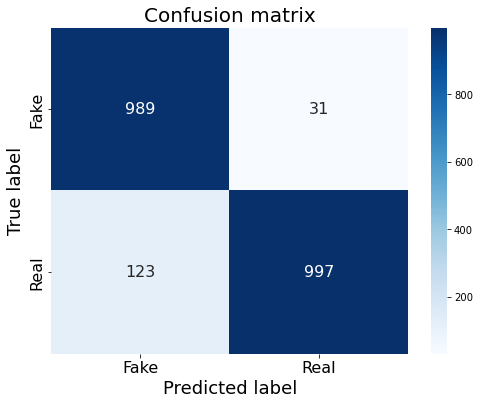

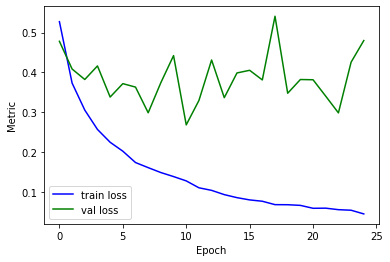

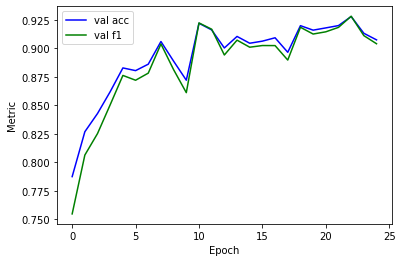

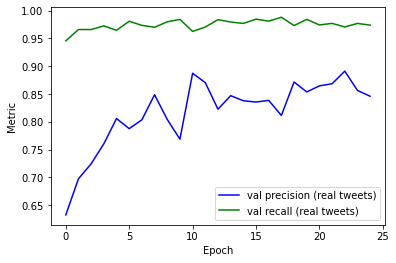

In [20]:
import seaborn as sns

# Best epoch
min_epoch = np.argmin(val_loss)
max_epoch_acc = np.argmax(val_acc)
max_epoch_f1 = np.argmax(val_f1)
print("Best val loss %f at epoch %d" % (val_loss[min_epoch], min_epoch))
print("Best val acc %f at epoch %d" % (np.max(val_acc), max_epoch_acc))
print("Best val F1 %f at epoch %d" % (np.max(val_f1), max_epoch_f1))

# Confusion matrix
confusion = confusion_matrix(val_labels[max_epoch_f1], val_predictions[max_epoch_f1])
plt.figure(figsize=(8,6))
heatmap = sns.heatmap(confusion, annot=True, xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'], fmt='d', cmap='Blues', annot_kws={"fontsize":16})
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 16)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 16)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label', fontsize=18)
plt.show()

# Metrics plots
plot_metrics(train_loss, val_loss, 'train loss', 'val loss')
plot_metrics(val_acc, val_f1, 'val acc', 'val f1')
plot_metrics(val_prec, val_recall, 'val precision (real tweets)', 'val recall (real tweets)')

## Evaluation

In [21]:
test_accuracy, test_precision, test_recall, test_f1 = test(model, test_dataloader)

print(f'Test accuracy: {test_accuracy}')
print(f'Test F1: {test_f1}')
print(f'Test precision: {test_precision}')

Test accuracy: 0.9174107142857143
Test F1: 0.9156439105730084
Test precision: 0.862442485623973
